In [49]:
import os
import numpy as np
import pandas as pd

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Get the GPU ready

In [51]:
import torch

In [52]:
if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the GPU


In [53]:
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset

In [54]:
import tarfile
from torchvision.datasets import CIFAR10
from torchvision import transforms as tt
from torch.utils.data import TensorDataset
from torchvision.datasets.utils import download_url

# Download the Data

In [55]:
flag = False # since the data has been downloaded and saved 

In [56]:
if flag:
    url = 'http://files.fast.ai/data/cifar10.tgz'
    download_url(url, '.')

In [57]:
if flag:
    with tarfile.open('cifar10.tgz') as  tar:
        tar.extractall()

In [62]:
f = open('./cifar10/labels.txt', 'r')
name = {}
count = 0

for label in f:
    name[label.strip()] = count
    count +=1

name

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [63]:
classes = {}

for val in name:
    classes[name[val]] = val

classes

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [64]:
# training data
if flag:
    X_train = []
    y_train = []

    for file in os.listdir('./cifar10/train'):
        for image in tqdm(os.listdir('./cifar10/train/' + file)):
            try:
                path = './cifar10/train/' + file + '/' + image
                img = torch.tensor(plt.imread(path))
                label = name[file]
                X_train.append(img)
                y_train.append(label)
            except:
                pass

In [65]:
# testing data
if flag:
    X_test = []
    y_test = []

    for file in os.listdir('./cifar10/test'):
        for image in tqdm(os.listdir('./cifar10/test/' + file)):
            try:
                path = './cifar10/test/' + file + '/' + image
                img = torch.tensor(plt.imread(path))
                label = name[file]
                X_test.append(img)
                y_test.append(label)
            except:
                pass

In [66]:
if flag:
    torch.save(X_train, 'X_train.pt')
    torch.save(X_test, 'X_test.pt')
    torch.save(y_train, 'y_train.pt')
    torch.save(y_test, 'y_test.pt')

# Load the Saved Data

In [70]:
X_train = torch.load('X_train.pt').permute(0,3,1,2)
X_test = torch.load('X_test.pt').permute(0,3,1,2)
y_train = torch.load('y_train.pt')
y_test = torch.load('y_test.pt')

In [71]:
def imread(img, label):
    print(classes[label.item()])
    plt.imshow(img.permute(1,2,0))

airplane


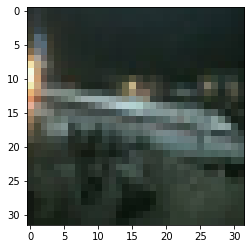

In [72]:
imread(X_test[0], y_test[0])

# DIviding Training Data into Batches

In [73]:
def split_indices(n, val_pct = 0.2, seed = 69):
    val = (int)(n * val_pct)
    np.random.seed(seed)
    perm = np.random.permutation(n)
    
    return perm[val:], perm[:val]

In [74]:
n = len(X_train)
train_ind, val_ind = split_indices(n)
print('Training Data:', len(train_ind))
print('Validation Data:', len(val_ind))

Training Data: 40000
Validation Data: 10000


In [75]:
batch_size = 128

X_val = X_train[val_ind]
X_train = X_train[train_ind]

y_val = y_train[val_ind]
y_train = y_train[train_ind]

data_test = TensorDataset(X_test, y_test)

In [76]:
# Apply data transformations to train, validation and test sets

stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

class Convert:
    def __call__(self, x):
        y = tt.ToPILImage()(x).convert("RGB")
        return y
    
train_trfm = tt.Compose([Convert(),
                         tt.RandomCrop(32, padding = 4, padding_mode = 'reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats)])

val_trfm = tt.Normalize(*stats)
test_trfm = tt.Normalize(*stats)

In [77]:
for i in tqdm(range(len(X_train))):
    X_train[i] = train_trfm(X_train[i])
    
for i in tqdm(range(len(X_val))):
    X_val[i] = val_trfm(X_val[i])
    
for i in tqdm(range(len(X_test))):
    X_test[i] = test_trfm(X_test[i])

data_train = TensorDataset(X_train, y_train)
data_val = TensorDataset(X_val, y_val)

In [78]:
# training data
train_dl = DataLoader(data_train,
                      batch_size,
                      shuffle = True)

# validation data
valid_dl = DataLoader(data_val,
                    batch_size,
                    shuffle = True)

# test data
test_dl = DataLoader(data_test, 
                     batch_size)

In [79]:
print('Training Data:', len(data_train))
print('Validation Data:', len(data_val))

Training Data: 40000
Validation Data: 10000


In [80]:
for x, y in train_dl:
    print(x.shape)
    break
    
for x, y in valid_dl:
    print(x.shape)
    break
    
for x, y in test_dl:
    print(x.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


# Batch of Transformed Images

In [81]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (16,16))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images[:100], 10).permute(1, 2, 0))
        break

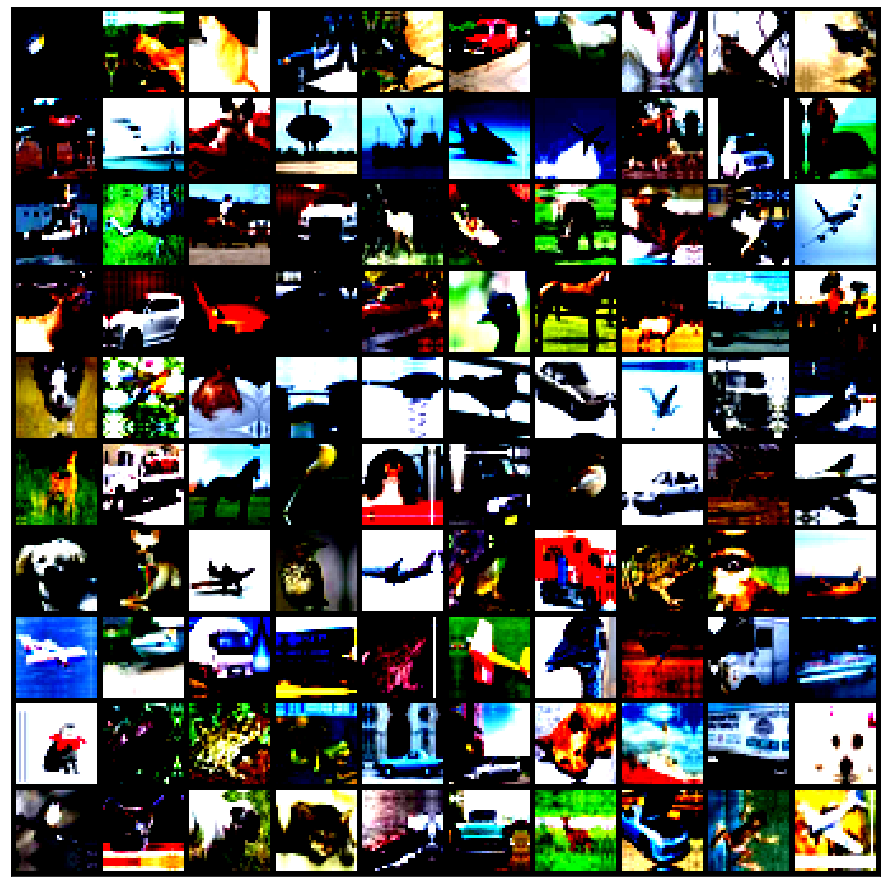

In [82]:
show_batch(train_dl)

# Creating the Model

In [83]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [84]:
class ResNet(nn.Module):
    
    def __init__(self, val):
        super().__init__()
        self.conv1 = nn.Conv2d(val, val, 3, padding = 1)
        self.conv2 = nn.Conv2d(val, val, 3, padding = 1)
        
    def __call__(self, x):
        self.x = x
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x += self.x
        
        return F.relu(x)

In [85]:
# Testing the ResNet
x = torch.randn(10,3,32,32)
res = ResNet(3)
res(x).shape

torch.Size([10, 3, 32, 32])

In [86]:
def conv_2d(ni, nf, stride=1, ks=3):
    return nn.Conv2d(in_channels=ni, out_channels=nf, 
                     kernel_size=ks, stride=stride, 
                     padding=ks//2, bias=False)

def bn_relu_conv(ni, nf):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                         nn.ReLU(inplace=True), 
                         conv_2d(ni, nf))

class ResidualBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, stride)
        self.conv2 = bn_relu_conv(nf, nf)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(ni, nf, stride, 1)
    
    def forward(self, x):
        x = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [87]:
def make_group(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride)
    rest = [ResidualBlock(nf, nf) for j in range(1, N)]
    return [start] + rest

class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

class WideResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()      
        # Increase channels to n_start using conv layer
        layers = [conv_2d(3, n_start)]
        n_channels = [n_start]
        
        # Add groups of BasicBlock(increase channels & downsample)
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i], 
                                 n_channels[i+1], stride)
        
        # Pool, flatten & add linear layer for classification
        layers += [nn.BatchNorm2d(n_channels[3]), 
                   nn.ReLU(inplace=True), 
                   nn.AdaptiveAvgPool2d(1), 
                   Flatten(), 
                   nn.Linear(n_channels[3], n_classes)]
        
        self.features = nn.Sequential(*layers)
        
    def forward(self, x): return self.features(x)
    
def wrn_22(): 
    return WideResNet(n_groups=3, N=3, n_classes=10, k=6)

In [33]:
model = wrn_22()

In [34]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])


# Training the Model

In [35]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

In [40]:
data = DataBunch(train_dl, valid_dl)
learner = Learner(data, model, loss_func=F.cross_entropy, metrics=[accuracy])
learner.clip = 0.1

In [41]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


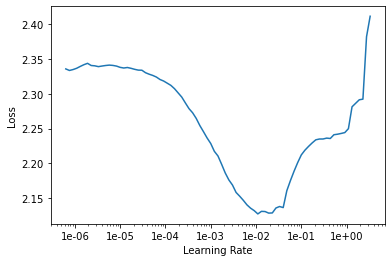

In [42]:
learner.recorder.plot()

In [43]:
learner.fit_one_cycle(9, 1e-3, wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.387819,1.358095,0.503900,00:50
1,1.027396,1.428889,0.538400,00:50
2,0.819175,0.918140,0.682000,00:50
3,0.621037,0.711239,0.748000,00:50
4,0.458047,0.612841,0.793500,00:50
5,0.286892,0.518279,0.830900,00:50
6,0.138683,0.515839,0.845800,00:50
7,0.045023,0.513611,0.857300,00:50
8,0.021028,0.527371,0.856800,00:50


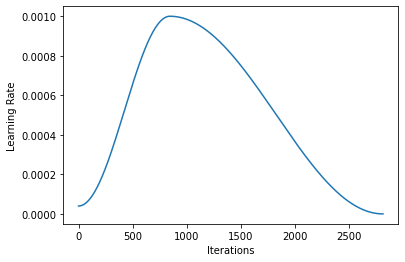

In [44]:
learner.recorder.plot_lr()

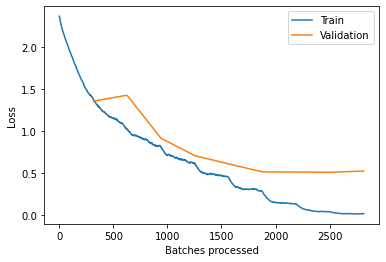

In [45]:
learner.recorder.plot_losses()

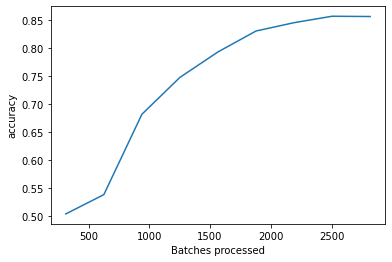

In [46]:
learner.recorder.plot_metrics()

# Testing the Model

In [91]:
def test(model):
    correct = 0
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_dl):
            pred = model(X_batch)
            correct += torch.sum(torch.argmax(pred, axis = 1) == y_batch).item()
            
    acc = correct / len(y_test)
    return acc

# Saving the Model

In [48]:
torch.save(model.state_dict(), 'cifar10-Res-Net.pty')

# Loading the Saved Model 

In [89]:
Model = wrn_22()

In [90]:
Model.load_state_dict(torch.load('cifar10-Res-Net.pty'))

<All keys matched successfully>

# Test Accuracy

In [93]:
print('Test Accuracy:', test(Model))


Test Accuracy: 0.1107
